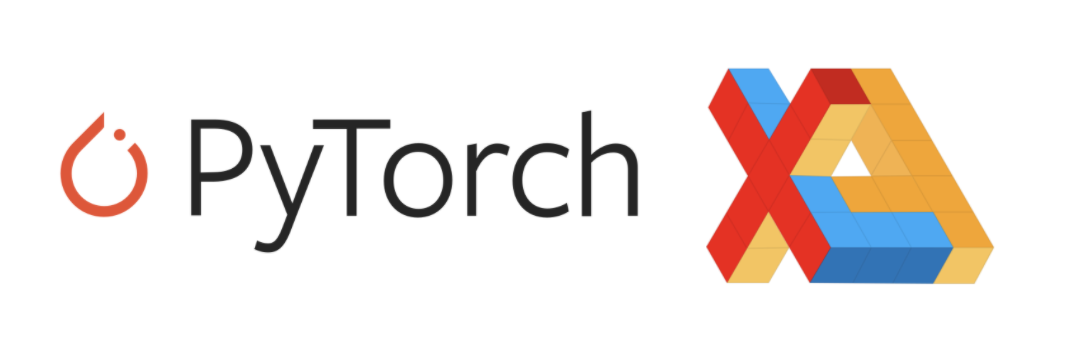

**PyTorch/XLA**

The PyTorch-TPU project was born out of a collaborative effort between the Facebook PyTorch and Google TPU teams and was officially launched at the 2019 PyTorch Developer Conference. This new integration enables PyTorch users to run and scale up their models on Cloud TPUs. PyTorch / XLA package lets PyTorch connect to Cloud TPUs and use TPU cores as devices

In [ ]:
!curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
!python pytorch-xla-env-setup.py --apt-packages libomp5 libopenblas-dev
!pip install timm

# **0. Importing Libraries**


PyTorch / XLA adds a new xla device type to PyTorch. This device type works just like other PyTorch device types.

In [ ]:
import os
import pandas as pd
from scipy import stats
import numpy as np
import glob
import tensorflow as tf
import timm
import random
import time
import copy
from operator import itemgetter

from collections import OrderedDict, namedtuple
import joblib

import logging
import sys

from PIL import Image
import cv2
import albumentations
import io
import IPython.display as display

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler
import torch.optim as optim
import torch_xla
import torch_xla.core.xla_model as xm
import torch_xla.debug.metrics as met
import torch_xla.distributed.parallel_loader as pl
import torch_xla.distributed.xla_multiprocessing as xmp
import torch_xla.utils.utils as xu
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import torchvision.transforms as transforms
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics, model_selection

import warnings
warnings.filterwarnings("ignore");

# **1. Data Loading**

**Paths**

In [ ]:
train_files = glob.glob('../input/tpu-getting-started/*/train/*.tfrec')
val_files = glob.glob('../input/tpu-getting-started/*/val/*.tfrec')
test_files = glob.glob('../input/tpu-getting-started/*/test/*.tfrec')

**Here we read tfrecords files in PyTorch. I recommend** https://medium.com/analytics-vidhya/how-to-read-tfrecords-files-in-pytorch-72763786743f

In [ ]:
train_feature_description = {
    'class': tf.io.FixedLenFeature([], tf.int64),
    'id': tf.io.FixedLenFeature([], tf.string),
    'image': tf.io.FixedLenFeature([], tf.string),
}

def _parse_image_function(example_proto):
  # Parse the input tf.Example proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, train_feature_description)

train_ids = []
train_class = []
train_images = []

for i in train_files:
  train_image_dataset = tf.data.TFRecordDataset(i)

  train_image_dataset = train_image_dataset.map(_parse_image_function)

  ids = [str(id_features['id'].numpy())[2:-1] for id_features in train_image_dataset] # [2:-1] is done to remove b' from 1st and 'from last in train id names
  train_ids = train_ids + ids

  classes = [int(class_features['class'].numpy()) for class_features in train_image_dataset]
  train_class = train_class + classes

  images = [image_features['image'].numpy() for image_features in train_image_dataset]
  train_images = train_images + images

In [ ]:
val_feature_description = {
    'class': tf.io.FixedLenFeature([], tf.int64),
    'id': tf.io.FixedLenFeature([], tf.string),
    'image': tf.io.FixedLenFeature([], tf.string),
}

def _parse_image_function(example_proto):
  # Parse the input tf.Example proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, val_feature_description)

val_ids = []
val_class = []
val_images = []

for i in val_files:
    val_image_dataset = tf.data.TFRecordDataset(i)

    val_image_dataset = val_image_dataset.map(_parse_image_function)

    ids = [str(image_features['id'].numpy())[2:-1] for image_features in val_image_dataset]
    val_ids += ids

    classes = [int(image_features['class'].numpy()) for image_features in val_image_dataset]
    val_class += classes 

    images = [image_features['image'].numpy() for image_features in val_image_dataset]
    val_images += images

In [ ]:
test_feature_description = {
    'id': tf.io.FixedLenFeature([], tf.string),
    'image': tf.io.FixedLenFeature([], tf.string),
}

def _parse_image_function_test(example_proto):
    return tf.io.parse_single_example(example_proto, test_feature_description)

test_ids = []
test_images = []
for i in test_files:
    test_image_dataset = tf.data.TFRecordDataset(i)
    
    test_image_dataset = test_image_dataset.map(_parse_image_function_test)

    ids = [str(id_features['id'].numpy())[2:-1] for id_features in test_image_dataset]
    test_ids = test_ids + ids

    images = [image_features['image'].numpy() for image_features in test_image_dataset]
    test_images = test_images + images

**Let's take a quick look at the data. I don't know about you, but the first thing I always want to do is look at what our data looks like :)**

In [ ]:
import IPython.display as display

display.display(display.Image(data=val_images[1]))

# **2. Data preparation**

**Let's write our dataset**

In [ ]:
class MyDataset():
    def __init__(self, ids, cls, imgs, transforms, is_test=False):
        self.ids = ids
        if not is_test:
            self.cls = cls
        self.imgs = imgs
        self.transforms = transforms
        self.is_test = is_test
    
    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        img = self.imgs[idx]
        img = Image.open(io.BytesIO(img))
        img = self.transforms(img)
        if self.is_test:
            return img, -1, self.ids[idx]
        return img, int(self.cls[idx]), self.ids[idx]

**Let's write augmentation and normalization right away**

In [ ]:
train_transforms = transforms.Compose([
                        transforms.RandomResizedCrop(224),
                        transforms.RandomHorizontalFlip(),
                        transforms.RandomVerticalFlip(),
                        transforms.ToTensor(),
                        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                        transforms.RandomErasing()
                    ])

test_transforms = transforms.Compose([
                        transforms.CenterCrop(224),
                        transforms.Resize(224),
                        transforms.ToTensor(),
                        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                    ])

In [ ]:
train_ds = MyDataset(train_ids, train_class, train_images, train_transforms)
valid_ds = MyDataset(val_ids, val_class, val_images, test_transforms)

In [ ]:
device = xm.xla_device()

In [ ]:
from torch.utils.data import Dataset, DataLoader, ConcatDataset

train_sampler = torch.utils.data.distributed.DistributedSampler(
        train_ds,
        num_replicas=xm.xrt_world_size(),
        rank=xm.get_ordinal(),
        shuffle=True
    )

valid_sampler = torch.utils.data.distributed.DistributedSampler(
        valid_ds,
        num_replicas=xm.xrt_world_size(),
        rank=xm.get_ordinal(),
        shuffle=True
    )
    
train_loader = DataLoader(train_ds, 128, sampler=train_sampler, num_workers=4, pin_memory=True)
val_loader = DataLoader(valid_ds, 128, sampler=valid_sampler, num_workers=4, pin_memory=True)

dataset_sizes = {
    'train': len(train_ds),
    'val': len(valid_ds),
}

In [ ]:
dataset_sizes

**We have already normalized the data, but at this stage I would like to dwell in more detail, because this is very important.**

In datasets, we have three-channel images, that is, we need to normalize for each channel separately (!!!). Because of the unnormalized data, problems may appear, for example, regularization during training can work to the detriment, but we do not want this at all. The task of normalization is to make the mean as close to zero as possible, and the standard deviation around 1.

How each channel looks separately can be seen below:

In [ ]:
transforms_example = transforms.Compose([
                        transforms.CenterCrop(224),
                        transforms.ToTensor(),])

exampleset = MyDataset(train_ids, train_class, train_images, transforms_example)

x, y, _ = next(iter(DataLoader(exampleset)))

channels = ['Red', 'Green', 'Blue']
cmaps = [plt.cm.Reds_r, plt.cm.Greens_r, plt.cm.Blues_r]

fig, ax = plt.subplots(1, 4, figsize=(15, 10))

for i, axs in enumerate(fig.axes[:3]):
    axs.imshow(x[0][i,:,:], cmap=cmaps[i])
    axs.set_title(f'{channels[i]} Channel')
    axs.set_xticks([])
    axs.set_yticks([])
    
ax[3].imshow(x[0].permute(1,2,0))
ax[3].set_title('Three Channels')
ax[3].set_xticks([])
ax[3].set_yticks([]);

**Now let's check how well we managed to normalize the data for each channel for the test, training and validation datasets:**

In [ ]:
channels = 3

loaders = {
    'train':train_loader,
    'val':val_loader,
}

for channel in range(channels):
    for x in ['train', 'val']:
        #number of pixels in the dataset = number of all pixels in one object * number of all objects in the dataset
        num_pxl = dataset_sizes[x]*224*224
    
        #we go through the butches and sum up the pixels of the objects, 
        #which then divide the sum by the number of all pixels to calculate the average
        total_sum = 0
        for batch in loaders[x]:
            layer = list(map(itemgetter(channel), batch[0]))
            layer = torch.stack(layer, dim=0)
            total_sum += layer.sum()
        mean = total_sum / num_pxl

        #we calculate the standard deviation using the formula that I indicated above
        sum_sqrt = 0
        for batch in loaders[x]: 
            layer = list(map(itemgetter(channel), batch[0]))
            sum_sqrt += ((torch.stack(layer, dim=0) - mean).pow(2)).sum()
        std = torch.sqrt(sum_sqrt / num_pxl)
        
        print(f'|channel:{channel+1}| {x} - mean: {mean}, std: {std}')

**Let's take a look at the pixel distribution after normalization**

In [ ]:
x, y, _ = next(iter(exampleset))

def plotHist(img):
  plt.figure(figsize=(10,5))
  plt.subplot(1,2,1)
  plt.imshow(x.permute(1,2,0))
  plt.axis('off')
  histo = plt.subplot(1,2,2)
  histo.set_ylabel('Count')
  histo.set_xlabel('Pixel Intensity')
  plt.hist(img.numpy().flatten(), bins=10, lw=0, alpha=0.5, color='r')

plotHist(x)

**Let's take a batch from the training dataset and see its mean and standard deviation:**

In [ ]:
x.mean(), x.std()

In [ ]:
def norm_out(img):
    
    img = img.permute(1,2,0)
    mean = torch.FloatTensor([0.485, 0.456, 0.406])
    std = torch.FloatTensor([0.229, 0.224, 0.225])
    
    img = img*std + mean
        
    return np.clip(img,0,1)

In [ ]:
def show_batch(dl):
    
    for images, labels, _ in dl:
        fig, ax = plt.subplots(figsize=(25, 25))
        ax.set_xticks([]); ax.set_yticks([])
        #images = norm_out(images[:60])
        ax.imshow(norm_out(make_grid(images[:60], nrow=10)))#.permute(1, 2, 0))
        ax.set_title('Images without augmentation', fontsize=40)
        break
        
show_batch(loaders['val'])

In [ ]:
def show_batch(dl):
    for images, labels, _ in dl:
        fig, ax = plt.subplots(figsize=(25, 25))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:60], nrow=10).permute(1, 2, 0))
        ax.set_title('Images with augmentation', fontsize=40)
        break
        
show_batch(loaders['train'])

# **3. Training and Test**
**Idea:** I will use an ensemble of pre-trained models, the idea is this: I first train only the classifier on 10 epochs, then unfreeze the network and train all together for another 10 epochs. After that, the model makes predictions on the test data

**Training for one epoch**

In [ ]:
def train(loader, epoch, model, optimizer, criterion):
   #tracker = xm.RateTracker()
   model.train()
   running_loss = 0.
   running_corrects = 0.
   tot = 0
   for i, (ip, tgt, _) in enumerate(loader):
      ip, tgt = ip.to(device), tgt.to(device)                            
      output = model(ip)
      loss = criterion(output, tgt)
      tot += ip.shape[0]

      # Append outputs
      _, pred = output.max(dim=1)
      running_corrects += torch.sum(pred == tgt.data)

      # compute gradient and do SGD step
      optimizer.zero_grad()
      loss.backward()
      #torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
      #optimizer.step()
      xm.optimizer_step(optimizer)

      running_loss += loss.item()*ip.size(0)

   return running_corrects, running_loss

**Val for one epoch**

In [ ]:
def test(loader, model, criterion):
        with torch.no_grad():
            model.eval()
            running_loss = 0.
            running_corrects = 0.
            tot = 0
            for i, (ip, tgt, _) in enumerate(loader):
                ip, tgt = ip.to(device), tgt.to(device)
                output = model(ip)
                loss = criterion(output, tgt)
                tot += ip.shape[0]
                _, pred = output.max(dim=1)
                running_corrects += torch.sum(pred == tgt.data)
                running_loss += loss.item()*ip.size(0)

            return running_corrects, running_loss

**Function for predictions on a test set**

In [ ]:
def predict(model, loader, device):
    with torch.no_grad():
        torch.cuda.empty_cache()
        model.eval()
        preds = dict()
        for i, (ip, _, ids) in enumerate(loader):
            ip = ip.to(device)
            output = model(ip)
            _, pred = output.max(dim=1)
            for i, j in zip(ids, pred.cpu().detach()):
                preds[i] = j
            
        return preds

**This is where we will record the history of learning, so that we can make visualization later. We need visualization to evaluate learning, for example, overfitting or underfitting. Of course, we can analyze with numbers, but it is much easier to perceive information visually**

In [ ]:
losses = {'train':[], 'val':[]}
accuracies = {'train':[], 'val':[]}

Fit function structure:

1. **Classifier Training**
2. **Network-wide Training**
3. **Predictions**

**In a typical XLA:TPU training scenario we’re training on multiple TPU cores in parallel (a single Cloud TPU device includes 8 TPU cores). So we need to ensure that all the gradients are exchanged between the data parallel replicas by consolidating the gradients and taking an optimizer step. For this we provide the xm.optimizer_step(optimizer) which does the gradient consolidation and step-taking**

In [ ]:
def fit(seed, epochs, model):

  # Train and valid dataloaders
  xm.master_print('Creating a model {}...'.format(seed))
  device = xm.xla_device()
  WRAPPED_MODEL = xmp.MpModelWrapper(model)
  model = WRAPPED_MODEL.to(device)
  model.to(device)  
  criterion = nn.CrossEntropyLoss()

  if seed==1:
        optimizer = torch.optim.Adam(model.head.parameters(), lr=0.001* xm.xrt_world_size(), betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
  if seed==2 or seed==3:
    optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001* xm.xrt_world_size(), betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
  if seed==4 or seed==0:
    optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.001* xm.xrt_world_size(), betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
#   scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.7, patience=3, verbose=True)

  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 4, gamma=0.1)
  since = time.time()
  best_model = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  for epoch in range(epochs):
    
    #train
    xm.master_print('Epoch: {}/{}'.format(epoch+1, epochs))
    para_loader = pl.ParallelLoader(train_loader, [device])
    running_corrects, running_loss = train(para_loader.per_device_loader(device), epoch, model, optimizer, criterion)
    epoch_loss = running_loss / dataset_sizes['train']
    epoch_acc = running_corrects/dataset_sizes['train']
    losses['train'].append(epoch_loss)
    accuracies['train'].append(epoch_acc)
    xm.master_print('{} - loss:{}, accuracy{}'.format('train', epoch_loss, epoch_acc))

    #val
    para_loader = pl.ParallelLoader(val_loader, [device])
    running_corrects, running_loss = test(para_loader.per_device_loader(device), model, criterion)
    epoch_loss = running_loss / dataset_sizes['val']
    epoch_acc = running_corrects/dataset_sizes['val']
    losses['val'].append(epoch_loss)
    accuracies['val'].append(epoch_acc)
    xm.master_print('{} - loss:{}, accuracy{}'.format('val', epoch_loss, epoch_acc))
    
    #epoch end
    xm.master_print('Time: {}m {}s'.format((time.time()- since)//60, (time.time()- since)%60))
    xm.master_print('=='*31)
    if epoch_acc > best_acc:
      best_acc = epoch_acc
      best_model = copy.deepcopy(model.state_dict())
    scheduler.step()
      
  time_elapsed = time.time() - since
  xm.master_print('CLASSIFIER TRAINING TIME {}m {}s'.format(time_elapsed//60, time_elapsed%60))
  xm.master_print('=='*31)


  model.load_state_dict(best_model)

  for param in model.parameters():
        param.requires_grad=True

  optimizer = torch.optim.Adam(model.parameters(), lr=0.0001* xm.xrt_world_size(), betas=(0.9, 0.999), eps=1e-08, weight_decay=0)  
#   scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.7, patience=3, verbose=True)
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 4, gamma=0.1)
  for epoch in range(epochs):

    #train
    xm.master_print('Epoch: {}/{}'.format(epoch+1, epochs))
    para_loader = pl.ParallelLoader(train_loader, [device])
    running_corrects, running_loss = train(para_loader.per_device_loader(device), epoch, model, optimizer, criterion)
    epoch_loss = running_loss / dataset_sizes['train']
    epoch_acc = running_corrects/dataset_sizes['train']
    losses['train'].append(epoch_loss)
    accuracies['train'].append(epoch_acc)
    xm.master_print('{} - loss:{}, accuracy{}'.format('train', epoch_loss, epoch_acc))

    #val
    para_loader = pl.ParallelLoader(val_loader, [device])
    running_corrects, running_loss = test(para_loader.per_device_loader(device), model, criterion)
    epoch_loss = running_loss / dataset_sizes['val']
    epoch_acc = running_corrects/dataset_sizes['val']
    losses['val'].append(epoch_loss)
    accuracies['val'].append(epoch_acc)
    xm.master_print('{} - loss:{}, accuracy{}'.format('val', epoch_loss, epoch_acc))
    
    #epoch end
    xm.master_print('Time: {}m {}s'.format((time.time()- since)//60, (time.time()- since)%60))
    xm.master_print('=='*31)
    if epoch_acc > best_acc:
      best_acc = epoch_acc
      best_model = copy.deepcopy(model.state_dict())
    scheduler.step()

  time_elapsed = time.time() - since
  xm.master_print('ALL NET TRAINING TIME {}m {}s'.format(time_elapsed//60, time_elapsed%60))
  xm.master_print('=='*31)

  model.load_state_dict(best_model)
    
  predictions = predict(model, testloader, device)
  for key in predictions.keys():
    ensemble_df.loc[ensemble_df['id'] == key, 'model_' + str(seed + 1)] = int((predictions[key]).item())
  
  xm.master_print('Prediction Saved! \n')

# **MODELS**

**1. DenseNet**

In [ ]:
densenet121 = torchvision.models.densenet121(pretrained=True)
for param in densenet121.parameters():
  param.requires_grad=False

densenet121.classifier = nn.Linear(in_features=densenet121.classifier.in_features, out_features=104, bias=True)

**2. ViT**

In [ ]:
ViT  = timm.create_model("vit_base_patch16_224", pretrained=True)
for param in ViT.parameters():
  param.requires_grad=False

ViT.head = nn.Linear(ViT.head.in_features, 104)

**3. GoogLeNet**

In [ ]:
googlenet = torchvision.models.googlenet(pretrained=True)
for param in googlenet.parameters():
  param.grad_requires = False

googlenet.fc = nn.Linear(in_features=googlenet.fc.in_features, out_features=104, bias=True)

**4. ResNet**

In [ ]:
resnet101 = torchvision.models.resnet101(pretrained=True)
for param in resnet101.parameters():
  param.grad_requires = False

resnet101.fc = nn.Linear(in_features=resnet101.fc.in_features, out_features=104, bias=True)

**5. VGG19**

In [ ]:
vgg19_bn = torchvision.models.vgg19_bn(pretrained=True)
for param in vgg19_bn.parameters():
  param.grad_requires = False

vgg19_bn.classifier[6] = nn.Linear(4096, 104, bias=True)

**Launching training**

In [ ]:
test_transforms = transforms.Compose([
                        transforms.CenterCrop(224),
                        transforms.Resize(224),
                        transforms.ToTensor(),
                        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                    ])

test_ds = MyDataset(test_ids, [], test_images, test_transforms, True)
testloader = DataLoader(test_ds, 128, num_workers=4, pin_memory=True, shuffle=False)

submit_df = pd.read_csv('../input/tpu-getting-started/sample_submission.csv')
ensemble_df = submit_df.copy()

num_models = 5
num_epochs = 10

models = [densenet121, ViT, googlenet, resnet101, vgg19_bn]

for seed in range(num_models):
   preds = fit(seed=seed, epochs=num_epochs, model=models[seed])

# **4. Submit Preparing**

In [ ]:
ensemble_df.head(10)

In [ ]:
# Final prediction
final_pred = ensemble_df.iloc[:,2:].mode(axis=1).iloc[:,0]
submit_df.label = final_pred.astype(int)
submit_df.head(10)

In [ ]:
# Create a submission file
submit_df.to_csv('submission11062021.csv', index=False)

# **5. Learning Visualization**

**As you can see, the idea of defrosting feature extractor worked and we see a sharp increase in accuracy**

In [ ]:
fig, ax = plt.subplots(5, 2, figsize=(15, 15))
modelname = ['DenseNet', 'ViT', 'GoogLeNet', 'ResNet101', 'VGG16 with BN']

epochs=10

i=0

for row in range(5):

  epoch_list = list(range(1,epochs*2+1))

  ax[row][0].plot(epoch_list, accuracies['train'][i:20+i], '-o', label='Train Accuracy')
  ax[row][0].plot(epoch_list, accuracies['val'][i:20+i], '-o', label='Validation Accuracy')
  ax[row][0].plot([epochs for x in range(20)],  np.linspace(min(accuracies['train'][i:20+i]).cpu(), max(accuracies['train'][i:20+i]).cpu(), 20), color='r', label='Unfreeze net')
  ax[row][0].set_xticks(np.arange(0, epochs*2+1, 5))
  ax[row][0].set_ylabel('Accuracy Value')
  ax[row][0].set_xlabel('Epoch')
  ax[row][0].set_title('Accuracy {}'.format(modelname[row]))
  ax[row][0].legend(loc="best")

  ax[row][1].plot(epoch_list, losses['train'][i:20+i], '-o', label='Train Loss')
  ax[row][1].plot(epoch_list, losses['val'][i:20+i], '-o',label='Validation Loss')
  ax[row][1].plot([epochs for x in range(20)], np.linspace(min(losses['train'][i:20+i]), max(losses['train'][i:20+i]), 20), color='r', label='Unfreeze net')
  ax[row][1].set_xticks(np.arange(0, epochs*2+1, 5))
  ax[row][1].set_ylabel('Loss Value')
  ax[row][1].set_xlabel('Epoch')
  ax[row][1].set_title('Loss {}'.format(modelname[row]))
  ax[row][1].legend(loc="best")
  fig.tight_layout()
  fig.subplots_adjust(top=1.5, wspace=0.3)

  i+=20